Umair Khan

# Examining the effects of a treatment on the cellular proteome
Using protein signal expression data with two conditions, control and treatment, I go through a standard workflow to assess the effects of a treatment at the cellular level.
Given two conditions with 3 replicates in each, I perform a Welch's t-test and use STRING to characterize proteins involved in treatment samplese but not control samples and vice versa.

In [481]:
# Import necessary packages
import numpy as np
import pandas as pd
import scipy
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
from statsmodels.stats.weightstats import ztest

Variance for all replicates in each conditions

control_1      4.327717
control_2      4.181819
control_3      4.281715
treatment_1    4.366995
treatment_2    4.147395
treatment_3    4.143432
dtype: float64


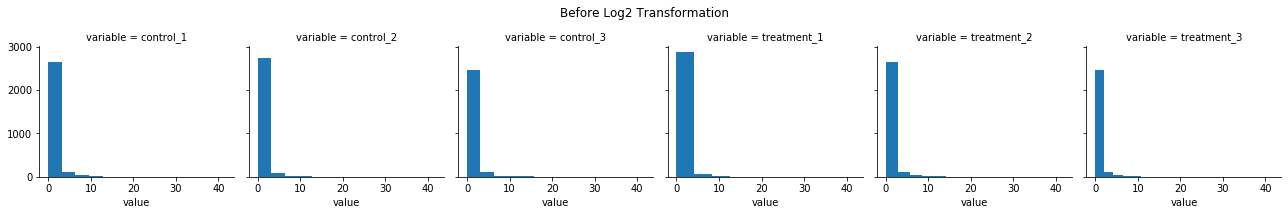

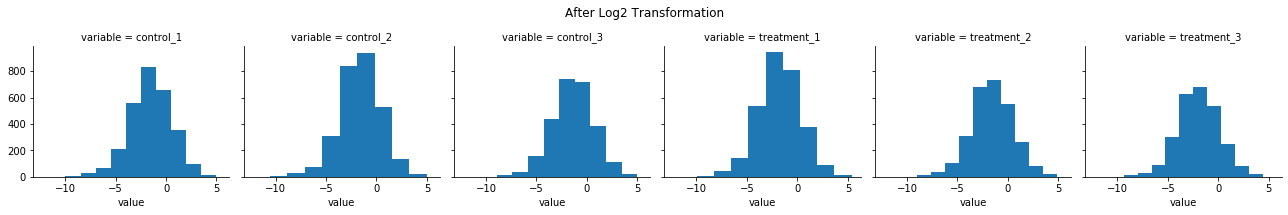

In [482]:
# Read file as a panda dataframe
# Plot initial distribution
df = pd.read_csv("ExampleData.txt", sep='\t')
df.set_index('protein_id',drop=True,inplace=True)
g = sns.FacetGrid(df.melt(), col="variable")
g.map(plt.hist, "value")
g.fig.suptitle('Before Log2 Transformation')
plt.subplots_adjust(top=0.80)

# Log2 Transformation/Plot distribution
df = np.log2(df)
g = sns.FacetGrid(df.melt(), col="variable")
g.map(plt.hist, "value")
g.fig.suptitle('After Log2 Transformation')
plt.subplots_adjust(top=0.80)

# Observe initial variances
print("Variance for all replicates in each conditions\n")
print(df.var())

The initial data distribution is skewed to the right so I apply a log base 2 transformation. I also observe the variance of all replicates in each condition which seems to be consistent for all. 

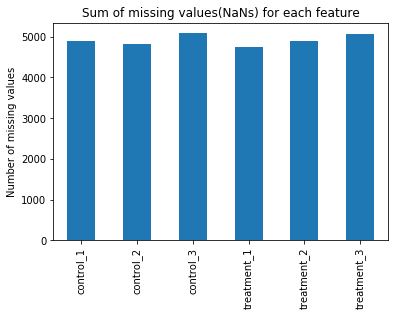

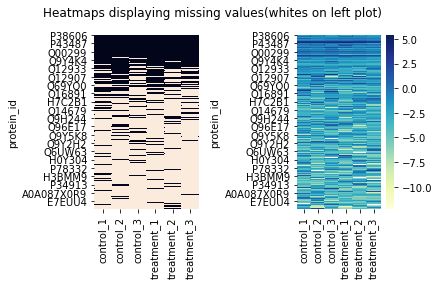

In [483]:
# Plot sum of missing values for each sample
df.isnull().sum().plot(kind='bar',title='Sum of missing values(NaNs) for each feature')
plt.ylabel('Number of missing values')
plt.show()

# Plot heatmaps
figure, axs = plt.subplots(nrows=1, ncols=2)
sns.heatmap(df.isnull(), cbar=False,ax=axs[0])
sns.heatmap(df, cmap="YlGnBu", mask=df.isnull(),ax=axs[1])
figure.suptitle('Heatmaps displaying missing values(whites on left plot)')
plt.tight_layout()
figure.subplots_adjust(top=0.88)

Understanding the missing values will help understand its relationship within the dataset. For the most part, it seems
missing values are present randomly or about uniform across most proteins. However, this is not to say that we remove
all since one condition(treatment) where all proteins are quantifiable compared to another condition(control) 
where we have missing values for the same protein implicates some biological response which would be of interest.

Count of missing values at each sample


control_1 : 793
control_2 : 739
control_3 : 889
treatment_1 : 692
treatment_2 : 746
treatment_3 : 824


Variance of technical replicates in each condition

control_1      2.982980
control_2      2.872554
control_3      2.831995
treatment_1    3.082268
treatment_2    3.035585
treatment_3    3.094558
dtype: float64


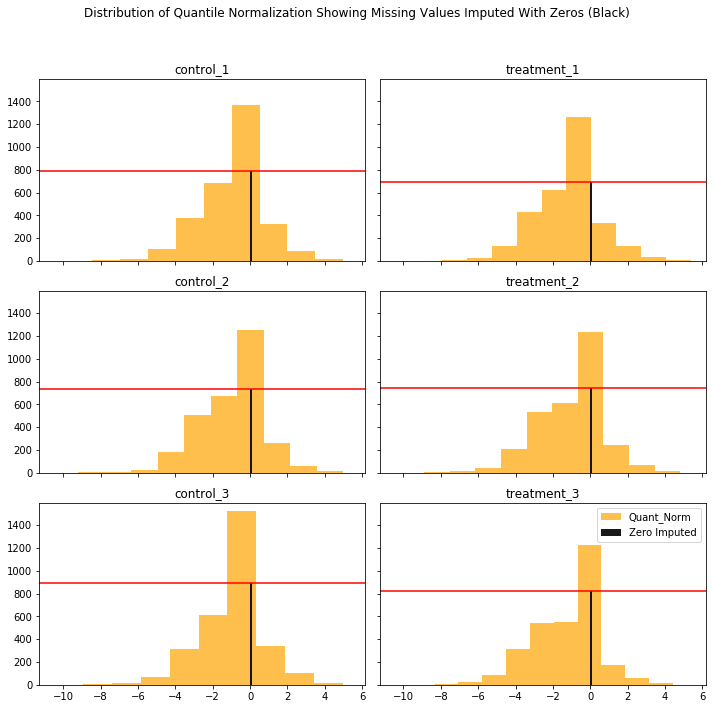

In [486]:
# Drop proteins that have missing values for all control and treatment samples and
# Keep proteins that are quantifiable in atleast 2/3 of both control or treatment
df.dropna(axis=0,how='all',inplace=True)
df_filt = df[ (df.iloc[:,:3].isna().sum(axis=1) <= 1) | (df.iloc[:,3:].isna().sum(axis=1) <=1 ) ]

# Compute quantile normalization and ignore NaNs
# Code taken from: https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
df_sorted = pd.DataFrame(np.sort(df_filt.values, axis=0), index=df_filt.index, columns=df_filt.columns)
df_mean = df_sorted.mean(axis=1)
df_mean.index = np.arange(1, len(df_mean) + 1)
df_filt.rank(method="min",na_option='keep').astype(float)
df_filt.rank(method="min",na_option='keep').stack().astype(float)
df_qn = df_filt.rank(method="min",na_option='keep').stack().astype(float).map(df_mean).unstack()

#Impute na values with 0 and indicate the columns that are missing 
df_c = df_qn.copy()
cols_with_missing = [col for col in df_c.columns if df_c[col].isnull().any()]
for col in cols_with_missing:
    df_c[col + '_missing'] = df_c[col].isnull()
    
# replace missing values with zero 
df_c.iloc[:,:6] = df.iloc[:,:6].fillna(0)

# Plot quantile normal distributions along with the imputed missing values
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(10,10),sharex=True,sharey=True)
ax0,ax1,ax2,ax3,ax4,ax5 = axes.flatten()
reorder = [ax0,ax2,ax4,ax1,ax3,ax5]


for ax,k,j in zip(reorder,df_c.columns[:6],df_c.columns[6:]):
    
    ax.hist(df_c[k],color='orange',alpha=0.7)
    ax.hist(df_c.loc[df_c[j]==True,k],color='black',alpha=0.9)
    plt.legend(['Quant_Norm','Zero Imputed'])
    ax.axhline(y=len(df_c.loc[df_c[j]==True,k]), color='r', linestyle='-')
    ax.set_title(k)
    fig.tight_layout() 
    
plt.suptitle('Distribution of Quantile Normalization Showing Missing Values Imputed With Zeros (Black)')
fig.subplots_adjust(top=0.88)
  
print('Count of missing values at each sample')
print('\n')
for n,m in zip(df_c.columns[:6],df_c.columns[6:]):
    print(f"{n} : {len(df_c.loc[df_c[m]==True,n])}")
print('\n')
# Check/confirm variance remains about the same in each replicate
print('Variance of technical replicates in each condition\n')
print(df_c.iloc[:,:6].var())

I start by filtering out non-quantifiable proteins that occur in all replicates in each condition. Then, I filter if proteins are quantifiable in atleast two-third of either control or treatment. This would help focus on changes among each condition to observe down or upregulation of proteins. I use quantile normalization to allow each condition to be in the same distribution to reduce bias and technical variation. This method allows values for each sample to be the same but preserve its original gene order. I then impute the missing values with zero and treat those as values with no or extremely low signal. Sklearn has many built-in functions for imputation methods but I avoid those as missing values have importance especially when comparing the effects of a treatment on the phenotypic level. I keep track of what proteins had missing values and plot its missing value frequency along with the distribution of the quantile normalized values. The number of missing values is consistent among each condition so it seems that, for the most part, the treatment may not have a signficant impact on the majority of samples that illicits a strong response. However, this only looks at the missing value count as a total and not individual sets of proteins that may be present or not in either condition. For that I perform a standard Welch's independent samples t-test.

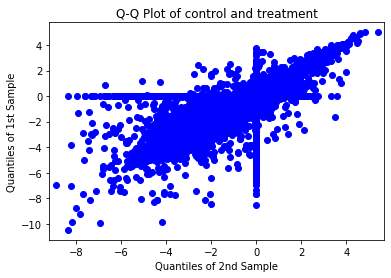

In [487]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
# Plot a qq plot
pp_c = sm.ProbPlot(df_c.iloc[:,:3])
pp_t = sm.ProbPlot(df_c.iloc[:,3:6])
qqplot_2samples(pp_c,pp_t)
plt.title('Q-Q Plot of control and treatment')
plt.show()
# Perform Welch's independent samples t-test which assumes variance is not the same between samples
# t-test for all genes(rows)
t_test = scipy.stats.ttest_ind(df_c.iloc[:, :3], df_c.iloc[:, 3:6], axis=1,equal_var=False)
# Create column with p-values
df_c['pvalue'] = t_test[1]
# Get proteins with statistically significant p-values only 
diff_proteins = df_c[df_c['pvalue'] < 0.05]

A qq plot shows that although samples may be linear following a normal distribution, there's an abundance of missing values in both samples. It is important to distinguish those proteins for later downstream analysis. Before I could do that, I will implement Welch's indepenedent samples t-test for all genes(across each row) to get p-values for each gene. I then filter that and retrieve only significant genes if the p-value of the test is < 0.05. 

In [496]:
print(f'Significant proteins not quantifiable in controls : {len(diff_proteins[(diff_proteins.iloc[:,:3].sum(axis=1) == 0)])}')
diff_proteins[(diff_proteins.iloc[:,:3].sum(axis=1) == 0)]

Significant proteins not quantifiable in controls : 39


,control_1,control_2,control_3,treatment_1,treatment_2,treatment_3,control_1_missing,control_2_missing,control_3_missing,treatment_1_missing,treatment_2_missing,treatment_3_missing,pvalue
protein_id,,,,,,,,,,,,,
O75746,0.0,0.0,0.0,-2.880445,-3.089267,-3.886833,True,True,True,False,False,False,0.008599
Q9Y5S9,0.0,0.0,0.0,-3.882571,-3.638456,-3.570036,True,True,True,False,False,False,0.000658
P35269,0.0,0.0,0.0,-2.541198,-2.477141,-2.560643,True,True,True,False,False,False,0.000100
E7EX53,0.0,0.0,0.0,-0.930710,-0.749523,-0.814514,True,True,True,False,False,False,0.004037
P49770,0.0,0.0,0.0,-1.873556,-2.607353,-2.617056,True,True,True,False,False,False,0.010658
P09429,0.0,0.0,0.0,-2.514573,-2.070967,-2.354022,True,True,True,False,False,False,0.003128
P37198,0.0,0.0,0.0,-3.198924,-3.376320,-3.140507,True,True,True,False,False,False,0.000479
H3BLU7,0.0,0.0,0.0,-2.738890,-3.693388,-2.972563,True,True,True,False,False,False,0.008292
O95297,0.0,0.0,0.0,-4.122805,-3.752437,-4.046921,True,True,True,False,False,False,0.000807


In [497]:
print(f'Significant proteins not quantifiable in treatments : {len(diff_proteins[(diff_proteins.iloc[:,3:6].sum(axis=1) == 0)])}')
diff_proteins[(diff_proteins.iloc[:,3:6]).sum(axis=1) == 0]

Significant proteins not quantifiable in treatments : 30


,control_1,control_2,control_3,treatment_1,treatment_2,treatment_3,control_1_missing,control_2_missing,control_3_missing,treatment_1_missing,treatment_2_missing,treatment_3_missing,pvalue
protein_id,,,,,,,,,,,,,
U3KQC1,-1.749038,-1.491673,-2.197600,0.0,0.0,0.0,False,False,False,True,True,True,0.012700
H0YH87,-0.980796,-1.422752,-1.610433,0.0,0.0,0.0,False,False,False,True,True,True,0.018907
B7ZC39,-2.078868,-3.039785,-3.649276,0.0,0.0,0.0,False,False,False,True,True,True,0.023599
Q9BT09,-2.455614,-2.557242,-2.867752,0.0,0.0,0.0,False,False,False,True,True,True,0.002220
H0YC70,-4.925769,-4.869860,-4.643856,0.0,0.0,0.0,False,False,False,True,True,True,0.000320
O75663,-1.754869,-2.524500,-1.895395,0.0,0.0,0.0,False,False,False,True,True,True,0.012960
Q8N6M0,-3.258425,-3.439089,-3.658356,0.0,0.0,0.0,False,False,False,True,True,True,0.001120
K7EJE8,-1.809448,-0.944527,-1.620157,0.0,0.0,0.0,False,False,False,True,True,True,0.030920
O95833,-3.511279,-3.629501,-3.891108,0.0,0.0,0.0,False,False,False,True,True,True,0.000930


Here, 39 proteins are not quantified in control samples but in treatments and 30 proteins are not quantified in treatments but in control samples. I could be more leniant and allow samples where atleast one replicate in either condition has measurement for a protein but for now, I will ignore. Annotating these sets of proteins would help distinguish the phenotypic level changes to predict protein behaviour and processes occuring for the treatment sample, as well as those processes that are not present. A functional annotation and an enrichment analysis would supplement this appropriately. 

The goal here was to identify proteins that help characterize treatments. Understanding how to manage missing values in proteomics datasets appropriately was puzzling so taking time focusing on what was appropriate to impute those values was needed. I had first used an iterative imputer but realized that may take away from comparing treatment and controls to make biological sense. 


To further understand the biological significance here, I will use STRING and observe protein-protein interactions. I remove disconnected nodes and threshold significance at 0.8 confidence.

In [499]:
# Write to file for STRING input

control_na = diff_proteins[(diff_proteins.iloc[:,:3].sum(axis=1) == 0)]
treatment_na = diff_proteins[(diff_proteins.iloc[:,3:6]).sum(axis=1) == 0]

with open('control_missing.txt','w') as file:
    
    file.write('\n'.join(control_na.index.tolist()))
    
with open('treatment_missing.txt','w') as file:
    
    file.write('\n'.join(treatment_na.index.tolist()))

Protein-protein interactions of proteins quantified in treatment but not in control seem to have a specific gene expression response mediating transcription including gene HMGB1 which is annotated to promote inflammatory response, infectious signals, and aid various DNA mechanisms. This, along with SMARCE1, AKR7A2, and PPIE along with the network these are included in seem to have an effect on transcriptional regulation and histone remodeling to mediate the internal cell environment in specific response to combat possibly free oxygen species and carcinogens.

<img src="control_missing.png" width="800" />

Protein-protein interactions of proteins quantified in control samples but not treatment have functions involving the possibility of cell growth, proliferation, and differentiation by OAS1, STAT1 which influences growth factors, and HLA-B which is involved in presenting foreign antigens. LONP1 and CLPX are responsible for mediating misfolded/oxidatively damaged polypeptides and short-lived regulatory proteins in the mitochondrial matrix. These functions suggest some irregularities occuring at the cellular level and a response towards something, to put it candidly, out of the ordinary. The amount of proteins used here is quite few. To be more inclusive, I could add proteins quantifed in atleast 1 or less samples for each condition. 

<img src="treatment_missing.png" width="800" />

For the statistically significant proteins(224 count), there seems to be a corrective response in treatment groups as described above. Both protein-protein interactions support the notion that proteins quantified in treatment induce a potentially remedial response within the cell in states of 'stress' or unusual behaviour. Downstream analysis can include differential gene network correlation analysis and gene set enrichment analysis.